In [2]:
bucket = 'stacking-ensemble'
#prefix = 'sagemaker/DEMO-stacking-ensemble'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Now let's bring in the Python libraries that we'll use throughout the analysis

In [13]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.serializers import CSVSerializer
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer, StandardScaler, OneHotEncoder

In [4]:
data_key = 'UCI_Credit_Card.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

data=pd.read_csv(data_location)
data.info()
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

Now lets read this into a Pandas data frame and take a look.

### Exploration
Let's start exploring the data.  First, let's understand how the features are distributed.

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


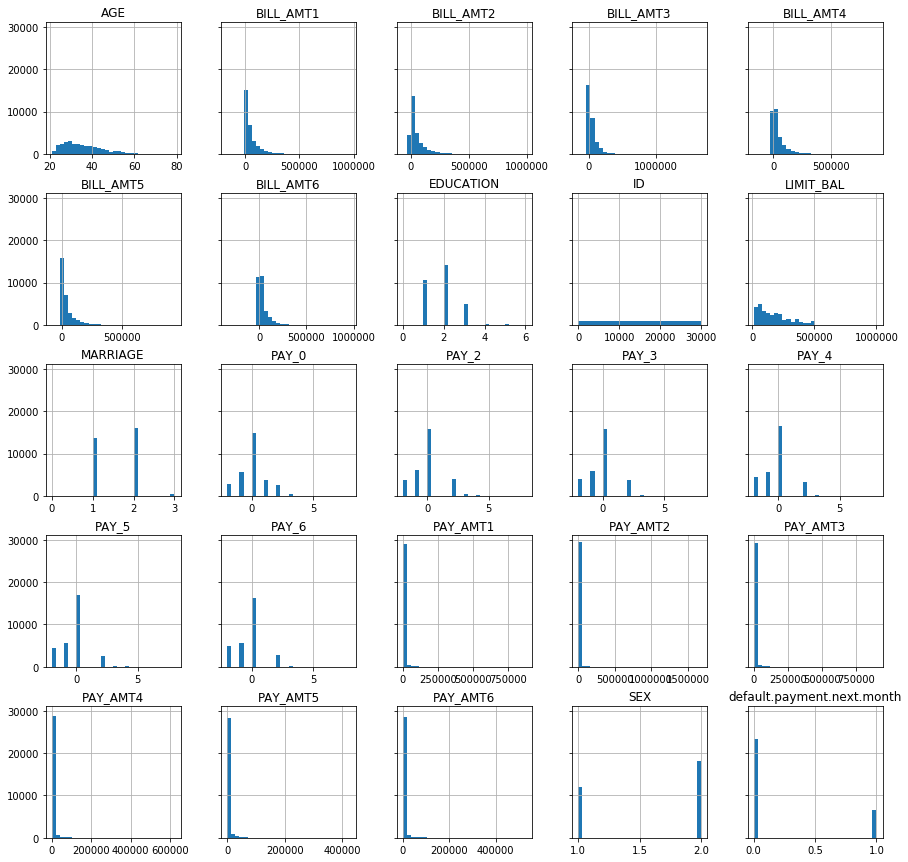

In [5]:
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(15, 15))

In [6]:
model_data = data.drop(['ID', 'default.payment.next.month'], axis=1)


In [7]:
feature_names =['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


numeric_features= data[['LIMIT_BAL', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

numeric_transformer= StandardScaler()
num_array=numeric_transformer.fit_transform(numeric_features)
print(num_array)
#print(numeric_array.shape)


categorical_features = data[['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
categorical_transformer = OneHotEncoder(handle_unknown='ignore').fit(categorical_features)
cat_array=categorical_transformer.transform(categorical_features).toarray()
#print(cat_array.shape)

processed_array=np.concatenate((num_array, cat_array), 1)

print(processed_array.shape)

[[-1.13672015  1.79456386  1.78234817 ... -0.30806256 -0.31413612
  -0.29338206]
 [-0.3659805  -0.87499115  1.78234817 ... -0.24422965 -0.31413612
  -0.18087821]
 [-0.59720239  0.01486052  0.1117361  ... -0.24422965 -0.24868274
  -0.01212243]
 ...
 [-1.05964618  3.57426721  2.61765421 ... -0.03996431 -0.18322937
  -0.11900109]
 [-0.67427636  0.90471219 -0.72356993 ... -0.18512036  3.15253642
  -0.19190359]
 [-0.90549825  0.01486052  0.1117361  ... -0.24422965 -0.24868274
  -0.23713013]]
(30000, 88)


In [8]:
processed_matirx= np.asmatrix(processed_array)
X_data=pd.DataFrame(processed_matirx)
Y_data = data[['default.payment.next.month']]

print(X_data)

             0         1         2         3         4         5         6   \
0     -1.136720  1.794564  1.782348 -0.696663 -0.666599 -1.530046 -1.486041   
1     -0.365981 -0.874991  1.782348  0.138865  0.188746  0.234917  1.992316   
2     -0.597202  0.014861  0.111736  0.138865  0.188746  0.234917  0.253137   
3     -0.905498  0.014861  0.111736  0.138865  0.188746  0.234917  0.253137   
4     -0.905498 -0.874991  0.111736 -0.696663  0.188746  0.234917  0.253137   
...         ...       ...       ...       ...       ...       ...       ...   
29995  0.404759  0.014861  0.111736  0.138865  0.188746  0.234917  0.253137   
29996 -0.134759 -0.874991 -0.723570 -0.696663 -0.666599  0.234917  0.253137   
29997 -1.059646  3.574267  2.617654  1.809921 -0.666599  0.234917  0.253137   
29998 -0.674276  0.904712 -0.723570  0.138865  0.188746  0.234917 -0.616452   
29999 -0.905498  0.014861  0.111736  0.138865  0.188746  0.234917  0.253137   

             7         8         9   ...   78   79 

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.30, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.30, random_state=42)

In [15]:
pd.concat([Y_train, X_train], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([Y_val, X_val], axis=1).to_csv('validation.csv', index=False, header=False)
#pd.concat([Y_test, X_test], axis=1).to_csv('test.csv', index=False, header=False)

In [17]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('validation/validation.csv')).upload_file('validation.csv')

In [18]:
container_1 = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [20]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/train'.format(bucket), content_type='text/csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/validation/'.format(bucket), content_type='text/csv')

In [213]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

In [174]:
# xgb_predictor = xgb.deploy(initial_instance_count=1,
#                            instance_type='ml.m4.xlarge',
#                            serializer = CSVSerializer()                          )

In [177]:
# def predict(data, rows=500):
#     split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
#     predictions = ''
#     for array in split_array:
#         predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

#     return np.fromstring(predictions[1:], sep=',')

# predictions = predict(X_test.to_numpy()[:,1:])
# predictions
# predictions.shape

In [193]:
# Y_test=Y_test.to_numpy()
# Y_test=Y_test.reshape(-1)

In [178]:
# pd.crosstab(index=Y_test, columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

# Model 2: Linear learner

In [218]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container_2 = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='linear-learner')


In [215]:
linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess,
    content_type='text/csv'
)
linear.set_hyperparameters(feature_dim=88, predictor_type="binary_classifier", mini_batch_size=200)

linear.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

## Deploy a multi container endpoint that can host both our learner and later we will add our meta learner model to it as well

In [235]:
container1 = { 'Image': container_1,
                'ContainerHostname': 'firstContainer',
             'ModelDataUrl': 's3://stacking-ensemble/sagemaker/DEMO-stacking-ensemble/output/xgboost-2021-04-28-05-04-25-082/output/model.tar.gz'}

container2 = { 'Image': container_2,
                'ContainerHostname': 'secondContainer',
              'ModelDataUrl':'s3://stacking-ensemble/sagemaker/DEMO-stacking-ensemble/output/linear-learner-2021-04-29-03-53-16-756/output/model.tar.gz'
             }
inferenceExecutionConfig = {'Mode': 'Direct'
                         }    

import boto3
sm_client = boto3.Session().client('sagemaker')

response = sm_client.create_model(ModelName = 'my-direct-model',
              InferenceExecutionConfig = inferenceExecutionConfig,
              ExecutionRoleArn = role,
              Containers = [container1, container2])

In [237]:
response = sm_client.create_endpoint_config(
    EndpointConfigName = 'my-epc',
    ProductionVariants=[{
        'InstanceType':        'ml.m4.xlarge',
        'InitialInstanceCount': 2,
        'InitialVariantWeight': 1,
        'ModelName':            'my-direct-model',
        'VariantName':          'AllTraffic'}])

In [239]:
response = sm_client.create_endpoint(
              EndpointName       = 'my-endpoint',
              EndpointConfigName = 'my-epc')

In [129]:
import json
runtime_sm_client = boto3.Session().client('sagemaker-runtime')
import io
from io import StringIO
csv_file = io.StringIO()
results_XGB=list()

for i in range(1,100):#len(X_test)):
    body=X_test.iloc[[i]]
    csv_file=io.StringIO()
    body.to_csv(csv_file, sep=",", header=False, index=False)
    payload = csv_file.getvalue()
    response = runtime_sm_client.invoke_endpoint(EndpointName ='my-endpoint',ContentType = 'text/csv',TargetContainerHostname='firstContainer', Body = payload)
    result = json.loads(response['Body'].read().decode())
    results_XGB.append(result)
print(results_XGB)

[0.11156003922224045, 0.15047086775302887, 0.09547748416662216, 0.19228462874889374, 0.18851794302463531, 0.41946861147880554, 0.3613850176334381, 0.09351055324077606, 0.16622887551784515, 0.773091733455658, 0.07973828166723251, 0.10850828886032104, 0.9144372940063477, 0.06028459221124649, 0.1510041058063507, 0.0753476619720459, 0.2025492936372757, 0.15857788920402527, 0.7176567316055298, 0.07905205339193344, 0.4029044210910797, 0.16399537026882172, 0.0707278847694397, 0.11528592556715012, 0.3891293406486511, 0.049366552382707596, 0.7961646914482117, 0.07213816791772842, 0.14590924978256226, 0.03136373683810234, 0.13460023701190948, 0.3281944990158081, 0.03232160955667496, 0.2660827338695526, 0.055967651307582855, 0.023182867094874382, 0.01214874442666769, 0.22937706112861633, 0.27400729060173035, 0.16165733337402344, 0.18428635597229004, 0.38301196694374084, 0.11606066673994064, 0.33051589131355286, 0.15572169423103333, 0.5150693655014038, 0.19646340608596802, 0.07664798945188522, 0.1

In [149]:
import json
runtime_sm_client = boto3.Session().client('sagemaker-runtime')
import io
from io import StringIO
csv_file = io.StringIO()
results_LL=list()

for i in range(1,100):#len(X_test)):
    body=X_test.iloc[[i]]
    csv_file=io.StringIO()
    body.to_csv(csv_file, sep=",", header=False, index=False)
    payload = csv_file.getvalue()
    response = runtime_sm_client.invoke_endpoint(EndpointName ='my-endpoint',ContentType = 'text/csv',TargetContainerHostname='SecondContainer', Body = payload)
    result = json.loads(response['Body'].read().decode())
    result=result['predictions'][0]['score']
    results_LL.append(result)
print(results_LL)

[0.1425866037607193, 0.21618054807186127, 0.2985113859176636, 0.23050788044929504, 0.11158045381307602, 0.3879971504211426, 0.2905397117137909, 0.07639910280704498, 0.15699070692062378, 0.5780773758888245, 0.11423643678426743, 0.21168535947799683, 0.8378437161445618, 0.13851593434810638, 0.11243318766355515, 0.17962419986724854, 0.27172067761421204, 0.07888223975896835, 0.6500892043113708, 0.17518986761569977, 0.2414344996213913, 0.2092496156692505, 0.210364431142807, 0.05831490829586983, 0.17339536547660828, 0.002300507389008999, 0.6900439858436584, 0.09674568474292755, 0.14838264882564545, 0.029345855116844177, 0.11786603927612305, 0.3834499418735504, 0.1523154377937317, 0.1787356585264206, 0.2535664141178131, 0.18775998055934906, 0.06162182614207268, 0.0531139001250267, 0.3304443657398224, 0.23828010261058807, 0.15262967348098755, 0.34814444184303284, 0.14508329331874847, 0.2251165211200714, 0.03790263831615448, 0.8032917380332947, 0.10689695924520493, 0.23760643601417542, 0.0989263

## Create level 2 (meta learner model) input data from outputs of the other two models

In [ ]:
from pandas import DataFrame
# XGB_features= 1- DataFrame(results_XGB)
# XGB_features=pd.concat([XGB_features, DataFrame(results_XGB)], axis=1)
def dataset_feature(input):
    feature=1-DataFrame(input)
    features=pd.concat([feature, DataFrame(input)], axis=1)
    return features

    
XGB_features=dataset_feature(results_XGB)    
#print(XGB_features)
LL_features=dataset_feature(results_LL)

MetaLearner_data=pd.concat([XGB_features, LL_features], axis=1)
print(MetaLearner_data)

In [ ]:
#load the data back onto S3 for training the Meta learner- we will use a KNN as our meta learner



In [ ]:
pd.concat([Y_train, X_train], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([Y_val, X_val], axis=1).to_csv('validation.csv', index=False, header=False)
#pd.concat([Y_test, X_test], axis=1).to_csv('test.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('validation/validation.csv')).upload_file('validation.csv')

## Define the Meta learner and add it to the endpoint we'd had already